# Exoplanets - Data Explotation

In this first notebook we are interested in the visualization of the exoplanet datasets from Kepler. This first step is critical to explore some of the proprieties of the dataset. The dataset is highly unbalanced and additionally, there are other effects such as rotating spots that will be here investigated.

In [1]:
import numpy as np
import pandas as pd

# processing
from sklearn.neighbors import LocalOutlierFactor

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

## Data import

In [2]:
df = pd.read_csv('data/Exoplanets/exoTrain.csv')

In [3]:
print("Shape of the dataframe:",df.shape)
df.head()

Shape of the dataframe: (5087, 3198)


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Descriptive statistics

In [4]:
# sampling some (10) of the columns to get an overview of the descriptive stat over the entire observation
columns_stats = df.columns[(np.linspace(1,3196, num=10, dtype=int))]
df[columns_stats].describe()

,FLUX.1,FLUX.356,FLUX.711,FLUX.1066,FLUX.1421,FLUX.1776,FLUX.2131,FLUX.2486,FLUX.2841,FLUX.3196
count,5.087000e+03,5087.000000,5087.000000,5.087000e+03,5087.000000,5087.000000,5087.000000,5.087000e+03,5087.00000,5087.000000
mean,1.445054e+02,-7.270228,234.442422,2.664807e+02,-79.800810,-272.337474,-433.208879,5.264644e+02,-58.42308,-440.239100
std,2.150669e+04,15614.137680,10714.940845,2.180033e+04,15261.021346,10626.572035,14732.999001,3.140800e+04,8233.48038,16273.406292
min,-2.278563e+05,-564770.000000,-161374.000000,-3.720245e+05,-467519.060000,-470727.000000,-573220.000000,-3.190231e+05,-269578.00000,-700992.000000
25%,-4.234000e+01,-16.730000,-13.470000,-1.694500e+01,-13.870000,-15.485000,-19.535000,-1.461500e+01,-20.33000,-21.135000
50%,-7.100000e-01,-1.220000,-0.640000,6.400000e-01,-1.030000,-1.230000,-1.880000,1.240000e+00,0.51000,0.900000
75%,4.825500e+01,11.570000,13.895000,1.765000e+01,12.910000,12.745000,11.835000,1.870000e+01,22.72000,19.465000
max,1.439240e+06,734437.500000,487857.000000,1.191991e+06,656580.000000,106804.500000,66432.120000,1.649051e+06,303589.50000,207590.000000


In [5]:
# number of planets per class
label_class, count = np.unique(df["LABEL"], return_counts=True)
print("There are {} stars with exoplanets and {} stars".format(count[1], count[0]))

# calculate imbalance ratio
ratio = count[1]/count[0]
print("The ratio of Exoplanets/Non-Exoplanets is {}%".format(np.around(ratio*100,3)))

There are 37 stars with exoplanets and 5050 stars
The ratio of Exoplanets/Non-Exoplanets is 0.733%


Text(0.5, 1.0, 'Box plot Mean-Flux distribution of Label 1 and 2')

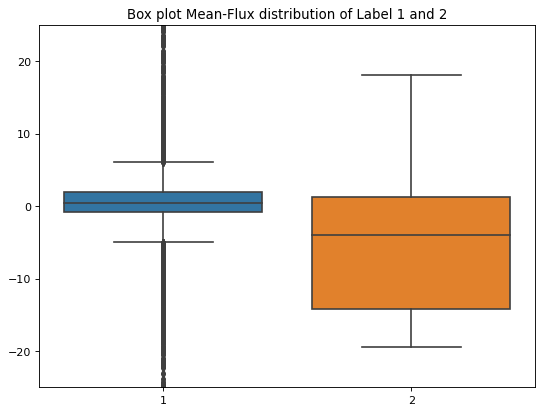

In [6]:
# calculate the average flux per label
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax= sns.boxplot(x=df["LABEL"].values, y=np.mean(df.loc[:,df.columns != "LABEL"].values, axis=1))
ax.set(ylim=(-25, 25))
ax.set_title('Box plot Mean-Flux distribution of Label 1 and 2')

## Timeseries visualization

In [7]:
def timeseries_exploration(df, label, remove_outliers=True):
    min_index, max_index = np.amin(df[(df["LABEL"]==label)].index), np.amax(df[(df["LABEL"]==label)].index)
    index_selected = np.random.randint(min_index,max_index,4)
    
    # plot with various axes scales
    plt.figure(figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    
    if remove_outliers:
        local_outlier = LocalOutlierFactor(n_neighbors=3)
        data = df.iloc[index_selected][df.columns[1:]]
        data_array = np.empty(data.shape)
        for idx in range (data.shape[0]):
            series = data.iloc[0]
            outliers = local_outlier.fit_predict(series.values.reshape(-1, 1))
            series.loc[outliers!=1] = np.mean(series)
            np.append(data_array, series)
    else:
        data_array = df.iloc[index_selected][df.columns[1:]].values
    
    ax1 = plt.subplot(221)
    ax1.plot(data_array[0,:])
    ax1.set_title('Timeseries label:{}, index:{}'.format(label,index_selected[0]))

    ax2 = plt.subplot(222)
    ax2.plot(data_array[1,:])
    ax2.set_title('Timeseries label:{}, index:{}'.format(label,index_selected[1]))

    ax3 = plt.subplot(223)
    ax3.plot(data_array[2,:])
    ax3.set_title('Timeseries label:{}, index:{}'.format(label,index_selected[2]))
    
    ax4 = plt.subplot(224)
    ax4.plot(data_array[3,:])
    ax4.set_title('Timeseries label:{}, index:{}'.format(label,index_selected[3]))
    
    plt.subplots_adjust(top=0.92, bottom=0.15, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

    plt.show()

Exoplanets Starts


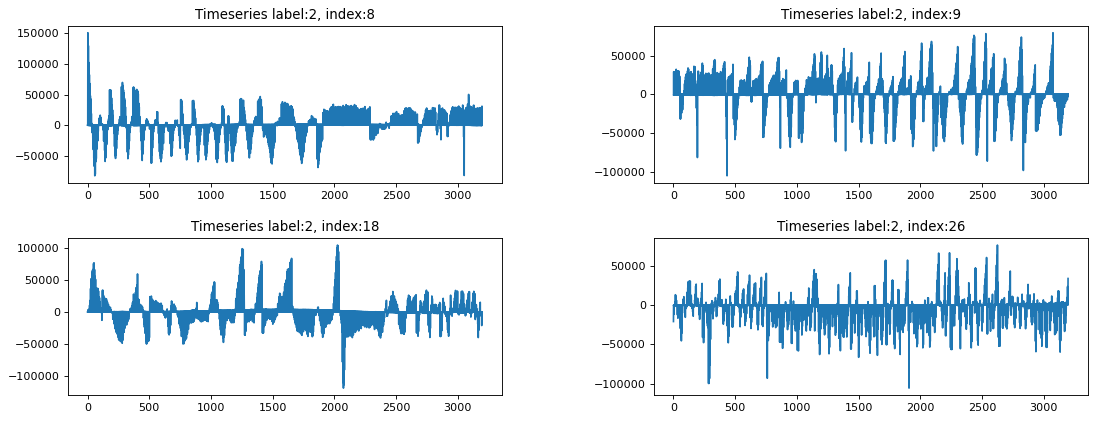

In [8]:
print("Exoplanets Starts")
timeseries_exploration(df, label=2, remove_outliers=True)

Non-Exoplanets Starts


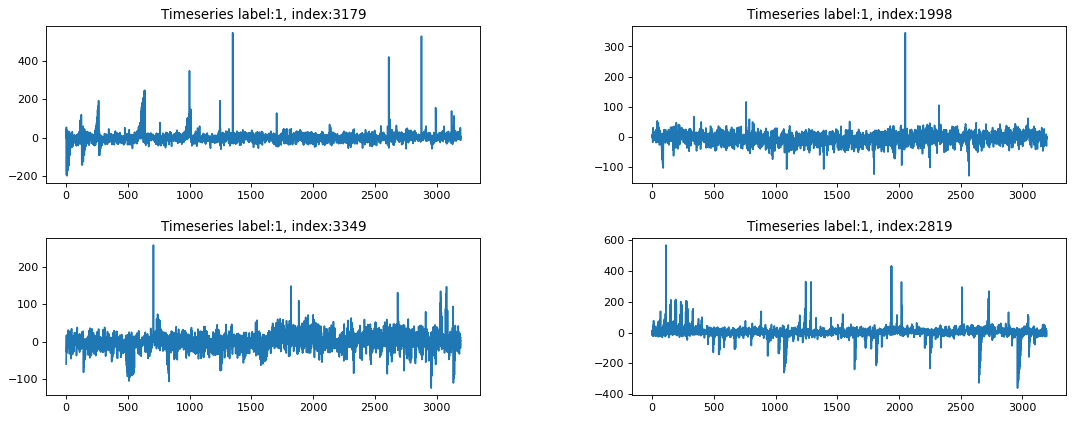

In [9]:
print("Non-Exoplanets Starts")
timeseries_exploration(df, label=1, remove_outliers=True)